# Practice Session 05: Recommendation engines (user-based)

In this practice we will develop a mobile phone recommender using user-based collaborative filtering.

# 0. Preliminaries

## 0.1. Datasets

In this practice we will come back to the data we used in the first practice session. This dataset corresponds to 16K registers of mobile device purchases in a telco company. Each record in the dataset describes the voice and data traffic consumption and billing profile for each customer that purchases a new mobile telephone.

The dataset has been processed into `re_dataset.csv` to generate new synthetic variables based on statistics. In particular, we have calculated the following statistics for each consumption variable (i.e. data traffic, voice traffic, billing and cost device) in a 6 months period:
- mean
- range: the difference between the maximum and minimum value among the 6 months value
- maximum relative: maximum value / mean
- minimum relative: minimum value / mean
- relative range: range / mean

Furthermore, from a business perspective, there is a new variable that could provide value to our model. This variable is the ratio between the device cost (i.e. how much the customer monthly spends to finance his/her current device) vs the total billing. For this new variable, we calculate as well its mean, range, maximum and minimum values. 

## 0.2. Required imports

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd   
from math import *
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import matplotlib.pyplot as plt

## 0.3 Load the data and first exploration

- Open the csv with separator "," and assign to a dataframe variable (use read_csv from Pandas library)
- Look at the head (first 5 registers)
- Evaluate the dimensionality of the dataset (number of rows and number of columns) and the type of the given variables (float, string, integer, etc.).

In [2]:
input_dataset=pd.read_csv("Datasets/re_dataset.csv", sep=",")

In [3]:
input_dataset.head(10)

,PURCHASED_DEVICE,NEW_COD_DEVICE,NEW_DEVICE_VALUE,DATA_TRAFFIC_MONTH_1,DATA_TRAFFIC_MONTH_2,DATA_TRAFFIC_MONTH_3,DATA_TRAFFIC_MONTH_4,DATA_TRAFFIC_MONTH_5,DATA_TRAFFIC_MONTH_6,DATA_RANGE,...,DEVICE_COST_BILLING_RATIO_RANGE,DEVICE_COST_AVG,DEVICE_COST_BILLING_RATIO_AVG,DEVICE_COST_MIN_REL,DEVICE_COST_MAX_REL,DEVICE_COST_RANGE_REL,DURATION_LINE,PREVIOUS_DEVICE_MODEL,PREVIOUS_DEVICE_MANUF,PREVIOUS_DEVICE_BRAND
0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,TGMO35912000,609.0,5014.103000,2659.051500,2659.051500,2435.039300,2053.979500,1553.115000,3460.988000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,54,K10a40,"Motorola Mobility LLC, a Lenovo Company",Outros
1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,DGAP068C2000,3465.0,1520.205600,2196.574500,2196.574500,1815.700900,2101.681600,3224.283400,1704.077800,...,0.000000,13.000000,8.856390,100.0,100.0,0.0,74,iPhone_6,Apple Inc,Apple
2,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,TGMO35912000,415.0,10789.820000,10423.674000,10423.674000,5188.596700,7379.404300,6789.482900,5601.223300,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,79,iPhone_6,Apple Inc,Apple
3,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...,TGLG29162000,321.0,4.177461,4.177461,1.889648,8.758789,0.000000,0.000000,8.758789,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,21,Samsung_Galaxy_J1_Mini,Samsung Korea,Samsung
4,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...,TGLG29162000,255.0,4550.795900,4297.518600,4297.518600,5398.457500,2456.808100,5073.480000,2941.649400,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,55,unknown,unknown,unknown
5,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...,TGLG29162000,255.0,2842.297900,850.088810,850.088810,1535.627100,962.114930,801.640500,2040.657400,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,55,unknown,unknown,unknown
6,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...,TGLG29162000,297.0,6566.303700,4594.519500,4594.519500,2257.108400,4465.744600,2471.750000,4309.195300,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,15,LG_Novo_K10,LG Electronics Inc.,LG
7,TGSA32564007_SAMSUNG J260M SMART PRETO PPB/PI...,TGSA32564007,633.0,4.528594,464.087740,695.095950,223.330200,223.330200,247.853820,690.567356,...,61.728395,2.500000,4.042691,0.0,600.0,600.0,128,Samsung_Galaxy_J1_Mini,Samsung Korea,Samsung
8,TGSA32162007_SAMSUNG J610G SMART PRETO PPB/PI1...,TGSA32162007,705.0,8396.934600,9907.531300,9907.531300,5994.021000,6872.605500,5246.003900,4661.527400,...,76.270276,47.333333,28.328047,0.0,150.0,150.0,245,Samsung_Galaxy_S4_Mini,Samsung Korea,Samsung
9,TGLG29462000_LG X410BCW SMARTPHONE PRETO PPB/P...,TGLG29462000,897.0,2958.771700,16.703360,16.703360,15.678672,31.404882,9.798711,2948.972989,...,106.534091,10.000000,14.765596,0.0,150.0,150.0,26,unknown,unknown,unknown


In [4]:
input_dataset.shape

(16232, 55)

In [5]:
input_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232 entries, 0 to 16231
Data columns (total 55 columns):
PURCHASED_DEVICE                   16232 non-null object
NEW_COD_DEVICE                     16232 non-null object
NEW_DEVICE_VALUE                   15872 non-null float64
DATA_TRAFFIC_MONTH_1               16232 non-null float64
DATA_TRAFFIC_MONTH_2               16232 non-null float64
DATA_TRAFFIC_MONTH_3               16232 non-null float64
DATA_TRAFFIC_MONTH_4               16232 non-null float64
DATA_TRAFFIC_MONTH_5               16232 non-null float64
DATA_TRAFFIC_MONTH_6               16232 non-null float64
DATA_RANGE                         16232 non-null float64
DATA_AVG                           16232 non-null float64
DATA_MIN_REL                       13926 non-null float64
DATA_MAX_REL                       13926 non-null float64
DATA_RANGE_REL                     13926 non-null float64
VOICE_TRAFFIC_MONTH_1              16232 non-null float64
VOICE_TRAFFIC_MONTH_2  

# 1. Building a recommendation engine

## 1.0. Exploratory data analysis


[**REPORT**] Evaluate the main statistics of the following numeric variables: **BILLING_AVG**, **VOICE_AVG** and **DATA_AVG**

In [6]:
print('Billing Average statistics:\n', input_dataset['BILLING_AVG'].describe(), '\n')
print('Voice Average statistics:\n', input_dataset['VOICE_AVG'].describe(), '\n')
print('Data Average statistics:\n', input_dataset['DATA_AVG'].describe(), '\n')

Billing Average statistics:
 count    16232.000000
mean       109.522225
std         64.963772
min          0.000000
25%         71.109583
50%        103.367500
75%        130.946250
max       1023.170000
Name: BILLING_AVG, dtype: float64 

Voice Average statistics:
 count    16232.000000
mean       140.072819
std        187.763361
min          0.000000
25%         29.129166
50%         80.225000
75%        179.770830
max       5171.416732
Name: VOICE_AVG, dtype: float64 

Data Average statistics:
 count    16232.000000
mean      3883.600622
std       6061.852456
min          0.000000
25%        200.017678
50%       1751.118797
75%       5018.173763
max      83475.756500
Name: DATA_AVG, dtype: float64 



[**REPORT**] Generate 3 plot with the distributions of **BILLING_AVG**, **DATA_AVG** and **VOICE_AVG** variables. Can you recognize any specific distribution (exponential, bimodal...)?

Tip: you can use [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html). Recommended options for this function are `hist=True, kde=False` which will plot the histogram but not try to create a kernel density estimation.

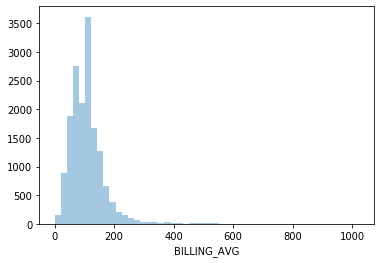

In [7]:
x = input_dataset['BILLING_AVG']
ax = sns.distplot(x, hist= True, kde=False)
fig = ax.get_figure()
fig.savefig("Tables/billing_dist.png")

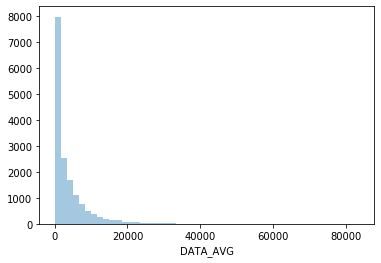

In [8]:
x = input_dataset['DATA_AVG']
ax = sns.distplot(x, hist= True, kde=False)
fig = ax.get_figure()
fig.savefig("Tables/data_dist.png")

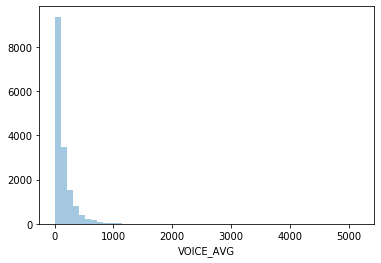

In [9]:
x = input_dataset['VOICE_AVG']
ax = sns.distplot(x, hist= True, kde=False)
fig = ax.get_figure()
fig.savefig("Tables/voice_dist.png")

[**REPORT**] Generate a table with a census of purchased mobile phones. This census will help us to know which is the current demand in the telco's customers. Which is the most purchased device? How many different types of mobile phones are? Does it make sense to apply a recommender? why?

In [10]:
#Census table
print('Census of purchased devices:')
print(input_dataset['PURCHASED_DEVICE'].value_counts().head(10))
print('-------------------------')
#Different types of mobile phones
print('There are', len(input_dataset['PURCHASED_DEVICE'].value_counts()) ,'different mobile phones.')

Census of purchased devices:
TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P1769/07    6406
TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO           1274
TGAL03462000_ALCATEL 5033J SMART PRETO                    744
TGLG29462000_LG X410BCW SMARTPHONE PRETO PPB/P1769/07     457
TGMO362C2000_MOTOROLA XT1944 SMARTPHONE PLATINUM          433
TGSA32162007_SAMSUNG J610G SMART PRETO PPB/PI107/04       413
TGSA31964007_SAMSUNG J410G SMART PRETO PPB/PI324/14       395
TGSA31962007_SAMSUNG J410G SMART PRETO PPB/PI107/04       377
TGAL03267000_ALCATEL 4034E SMARTPHONE PIXI4-4  PRETO      354
TGMO36762000_MOTOROLA XT1941 SMARTPHONE PRETO             286
Name: PURCHASED_DEVICE, dtype: int64
-------------------------
There are 116 different mobile phones.


## 1.1. Data preparation: Variable selection and standarization

Even though we have a great dataset, not all variables will be useful. In some occasions, introducing a new variable in the dataset could deteriorate the performance of the model. 
In our case, we have to select those variables that can help us to our final purpose (i.e. suggest a list of mobile phones to the telco's customers) taking into the technique we are going to use: a user-based collaborative filtering. Because of that we have should select those variables that explain better the users' behaviour.
This variable selection is usually iterative.

Let's create a new dataset considering the following variables: **DATA_RANGE**, **DATA_AVG**,  **VOICE_RANGE**, **VOICE_AVG**,**BILLING_RANGE**, **BILLING_AVG**, **DEVICE_COST_RANGE**, **DEVICE_COST_AVG** and **DEVICE_COST_BILLING_RATIO_AVG**

In [11]:
input_dataset_limit=input_dataset[["PURCHASED_DEVICE","DATA_RANGE", "DATA_AVG",  "VOICE_RANGE", "VOICE_AVG","BILLING_RANGE", "BILLING_AVG", "DEVICE_COST_RANGE", "DEVICE_COST_AVG","DEVICE_COST_BILLING_RATIO_AVG"]]

In [12]:
input_dataset_limit.head()

,PURCHASED_DEVICE,DATA_RANGE,DATA_AVG,VOICE_RANGE,VOICE_AVG,BILLING_RANGE,BILLING_AVG,DEVICE_COST_RANGE,DEVICE_COST_AVG,DEVICE_COST_BILLING_RATIO_AVG
0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,3460.988000,2729.056633,383.899990,63.983332,2.70,109.700000,0.0,0.0,0.00000
1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,1704.077800,2175.836750,344.000030,415.566670,71.31,146.786667,0.0,13.0,8.85639
2,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,5601.223300,8499.108650,64.300003,10.800000,39.99,118.433333,0.0,0.0,0.00000
3,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...,8.758789,3.167226,18.600000,8.550000,0.04,103.133333,0.0,0.0,0.00000
4,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...,2941.649400,4345.763117,325.700010,54.283335,304.95,154.901667,0.0,0.0,0.00000


In [13]:
input_dataset_limit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232 entries, 0 to 16231
Data columns (total 10 columns):
PURCHASED_DEVICE                 16232 non-null object
DATA_RANGE                       16232 non-null float64
DATA_AVG                         16232 non-null float64
VOICE_RANGE                      16232 non-null float64
VOICE_AVG                        16232 non-null float64
BILLING_RANGE                    16232 non-null float64
BILLING_AVG                      16232 non-null float64
DEVICE_COST_RANGE                16232 non-null float64
DEVICE_COST_AVG                  16232 non-null float64
DEVICE_COST_BILLING_RATIO_AVG    16154 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


[**CODE**] To avoid any issue with the correlation matrix, we should eliminate any row of the dataframe with **NaN** values. 

In [14]:
input_dataset_limit = input_dataset_limit.dropna()

Check all rows don't have any null variable. It should look like:

In [15]:
input_dataset_limit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16154 entries, 0 to 16231
Data columns (total 10 columns):
PURCHASED_DEVICE                 16154 non-null object
DATA_RANGE                       16154 non-null float64
DATA_AVG                         16154 non-null float64
VOICE_RANGE                      16154 non-null float64
VOICE_AVG                        16154 non-null float64
BILLING_RANGE                    16154 non-null float64
BILLING_AVG                      16154 non-null float64
DEVICE_COST_RANGE                16154 non-null float64
DEVICE_COST_AVG                  16154 non-null float64
DEVICE_COST_BILLING_RATIO_AVG    16154 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


As user-based collaborative filtering is high intensive in terms of computation requirements, we are going to take a sample of 2K registers.

In [16]:
input_dataset_limit = input_dataset_limit[0:2000].reset_index(drop=True)

In [17]:
input_dataset_limit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
PURCHASED_DEVICE                 2000 non-null object
DATA_RANGE                       2000 non-null float64
DATA_AVG                         2000 non-null float64
VOICE_RANGE                      2000 non-null float64
VOICE_AVG                        2000 non-null float64
BILLING_RANGE                    2000 non-null float64
BILLING_AVG                      2000 non-null float64
DEVICE_COST_RANGE                2000 non-null float64
DEVICE_COST_AVG                  2000 non-null float64
DEVICE_COST_BILLING_RATIO_AVG    2000 non-null float64
dtypes: float64(9), object(1)
memory usage: 156.3+ KB


## 1.2. User-based collaborative filtering

In the user-based collaborative filtering, the recommended products for a user_1 are based on others similar users' products. For example if Derrick and Dennis like the same movies and a new movie comes out that Derick likes, then we can recommend that movie to Dennis because Derrick and Dennis seem to like the same movies.

Therefore, in user-based collaborative filtering, the similarity calculation will be apply to user-to-user.

[**REPORT**] Explain some cons and pros of user-based collaborative filtering.

[**CODE**] Complete the `user_collaborative_filtering` function to select the top_n recommendations based on the user similarity. Store the recommendation in a new dataset with the following columns: **ID_original**: original user_id, **Real_purchase**: device purchased by user_id, **ID_similar**: id of other user "similar" to user_id, **similarity**: value of cosine similarity between user_id and "ID_similar" user, **Recommended_device**: device purchased by user with ID_similar. To support your code we provide two functions:
   - `recommendation_store`: will add the calculated recommendations for each user in the new top_n_dataset table
   - `user_selection`: will select the closer users whose cosine similarity are > similarity_level value 

Tip: use [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to compute cosine similarity between two arrays.

In [18]:
def recommendation_store(user_index, aux_index, dataset, id_indices, similarity_levels, top_n_dataset):
    for j in range (len(id_indices)):
            top_n_dataset.loc[aux_index+j]=[user_index,dataset.loc[user_index,"PURCHASED_DEVICE"],id_indices[j],similarity_levels[j]*100,dataset.loc[id_indices[j],"PURCHASED_DEVICE"]]
    return top_n_dataset

In [19]:
def user_selection (user_similarity, similarity_level, index, top_n):
    sim_scores = list(enumerate(user_similarity[index]))
    
    #Order the score list based on the user_similarity value and select the top_n
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    
    #Select the closer users if cosine_similarity is higher than the minimum similarity value (i.e. similarity_level) 
    id_indices=[i[0] for i in sim_scores if i[1]>similarity_level]
    similarity_levels=[i[1] for i in sim_scores if i[1]>similarity_level]
    
    return id_indices, similarity_levels

In [20]:
def user_collaborative_filtering (dataset, similarity_level, top_n):
    
    # Create a dataframe that will contain the output of the recommendation
    top_n_dataset = pd.DataFrame(columns=["ID_original","Real_purchase","ID_similar","similarity", "Recommended_device"])
    
    # Calculate de cosine similarity excluding the "PURCHASED_DEVICE" from the dataset
    # - create a variable dataset_aux that does not contain PURCHASED_DEVICE
    # - create variable user_similarity containing pairwise cosine similarities in this dataset
    ## ADD YOUR CODE HERE
    dataset_aux = dataset.loc[:, dataset.columns != 'PURCHASED_DEVICE']
    user_similarity = cosine_similarity(dataset_aux)
    
    #Extra: Data Visualization
    print('Similarity matrix of the dataset:')
    plt.imshow(user_similarity, cmap="gray")
    plt.show()
    
    # Select the top_n users closer (i.e. more similar) to each user_id that satisfy the minimum similarity value
    aux_index=0
    for user_index in range(len(user_similarity)):
        # Select the "top_n" closer users that satisfy that cosine_similarity is higher than
        # the minimum similarity value (i.e. similarity_level) 
        # - create variable "id_indices" with the IDs of those users
        # - create variable "similarity_levels" wih the similarities of those users
        ## ADD YOUR CODE HERE        
        id_indices, similarity_levels = user_selection(user_similarity, similarity_level, user_index, top_n)
        
        # Store the recommendation in the new dataset (i.e, "top_n_dataset")
        ## ADD YOUR CODE HERE
        top_n_dataset = recommendation_store(user_index, aux_index, dataset, id_indices, similarity_levels, top_n_dataset)
        
        # Update aux_index according to the number of recommendations for this user_index
        aux_index=aux_index+len(id_indices)
        
    return top_n_dataset


Once we have build our user_similarity function, apply it for: **num of recommendations=5** and **threshold of similarity=0.40**.

Similarity matrix of the dataset:


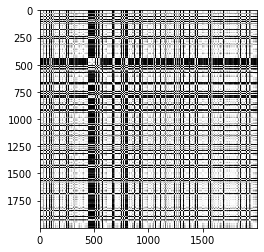

In [21]:
min_similarity_level=0.40
num_recommendations=5
top_n=user_collaborative_filtering(input_dataset_limit,min_similarity_level,num_recommendations)

[**REPORT**] Generate a table with the recommendations for the 5 first users. Do the results make sense? Explain how the device recommender works comparing users' profile (i.e. ID_original user vs ID_similar users) in terms of variables we use to calculate the similarity between users.

Your recommendations should look like this. `ID_original` is the original customer ID. `ID_similar` is another customer, whose similarity to customer `ID_original` is `similarity`.

In [22]:
top_n.head(30).to_excel("Tables/head.xlsx")
top_n.head(30)

,ID_original,Real_purchase,ID_similar,similarity,Recommended_device
0,0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,234,99.968290,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO
1,0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,101,99.955756,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...
2,0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,1373,99.949734,DGAP049C2007_APPLE IPHONE 6S 32GB CINZA PPB/P...
3,0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,311,99.928233,TGMO36762000_MOTOROLA XT1941 SMARTPHONE PRETO
4,0,TGMO35912000_MOTOROLA XT1922 SMARTPHONE INDIGO,274,99.917745,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...
5,1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,1581,99.884716,TGLG29162000_LG X210BMW SMARTPHONE PRETO PPB/P...
6,1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,1748,99.847545,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...
7,1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,170,99.747803,TGAL03267000_ALCATEL 4034E SMARTPHONE PIXI4-4 ...
8,1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,1088,99.739287,TGMO36812000_MOTOROLA XT1965 SMARTPHONE INDIGO
9,1,DGAP068C2000_APPLE IPHONE 8 256GB CINZA PPB/PI...,1225,99.737630,TGMO36762000_MOTOROLA XT1941 SMARTPHONE PRETO


[**CODE**] Build a function to evaluate de performance. In our case, we will consider as a **success** those device recommendations that are equal to the real purchase device by the customers. Therefore, from the previous dataset, **top_n**, you should compare the **Real_purchase** vs **Recommended_device** user by user, and indicate in what percentage of cases they are equal, and hence you did a perfect recommendation.

In [23]:
def performance_evaluation(top_n):
    match = top_n[top_n['Real_purchase'] == top_n['Recommended_device']]['ID_original'].nunique()
    total = top_n['ID_original'].nunique()
    percent = 100 * match / total
    print('Ratio of recommendation where Recommended Devices contain Real Purchase:', str(percent) + '%')

In [24]:
#Solution
performance_evaluation(top_n)

Ratio of recommendation where Recommended Devices contain Real Purchase: 42.65%


[**REPORT**] Repeat the previous process with other subset of variables for `input_dataset_limit=input_dataset_limit["PURCHASED_DEVICE", "DATA_AVG","BILLING_AVG", "DEVICE_COST_AVG", "DEVICE_COST_BILLING_RATIO_AVG"]`. Explain the results.

Similarity matrix of the dataset:


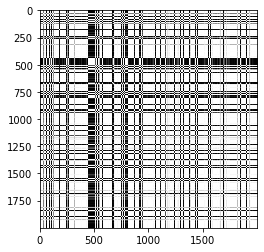

Ratio of recommendation where Recommended Devices contain Real Purchase: 46.1%


In [25]:
new_input_dataset = input_dataset_limit[["PURCHASED_DEVICE", "DATA_AVG","BILLING_AVG", "DEVICE_COST_AVG", "DEVICE_COST_BILLING_RATIO_AVG"]]
top_n=user_collaborative_filtering(new_input_dataset,min_similarity_level,num_recommendations)
performance_evaluation(top_n)

# 2. Deliver

Deliver:

* A zip file containing your notebook (.ipynb file) with all the [**CODE**] parts implemented.
* A 4-pages PDF report including all parts of this notebook marked with "[**REPORT**]"

The report should end with the following statement: **I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.**